In [3]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = ''
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting CUDA visible devices to []


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from jax.scipy.stats import gaussian_kde

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys

sys.path.append('/scratch/big/home/maxhin/Documents/Repos/bamojax/')

from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

sys.path.append('/scratch/big/home/maxhin/Documents/Repos/bamojax')

from bamojax.base import Model
from bamojax.sampling import gibbs_sampler, mcmc_sampler
from bamojax.inference import SMCInference, MCMCInference
from bamojax.more_distributions import AutoRegressionFactory


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: cpu
Jax devices:         [CpuDevice(id=0)]


Plotting functions:

In [15]:


def plot_kde(ax, states, color, z_index=1):
    lb, ub = jnp.percentile(states, q=jnp.array([0., 99.9]))
    var_range = jnp.linspace(lb, ub, num=200)
    pdf = gaussian_kde(states)
    density = pdf(var_range)
    ax.plot(var_range, density, color='k', lw=1, zorder=2*z_index+1)
    ax.fill_between(var_range, density, jnp.zeros_like(density), color=color, alpha=0.7, zorder=2*z_index)
    ax.set_xlim([lb, ub])
    ax.set_ylim(bottom=0)

#
def plot_posterior(states, ground_truth: dict = None):
    order = states['y0'].shape[1]
    num_coef = states['coefficients'].shape[1]

    _, axes = plt.subplots(nrows=2, ncols=num_coef, figsize=(18, 6), constrained_layout=True)
    for i in range(num_coef):
        plot_kde(axes[0, i], states['coefficients'][:, i], color='tab:blue', z_index=i)
        axes[0, i].set_title(rf'$\beta_{i}$')
        if ground_truth is not None:
            axes[0, i].axvline(x=ground_truth['coefficients'][i], ls='--', color='k')

    plot_kde(axes[1, 0], states['sigma_y'], color='tab:green')
    if ground_truth is not None:
        axes[1, 0].axvline(x=ground_truth['sigma_y'], ls='--', color='k')
    axes[1, 0].set_title(r'$\sigma_y$')
    for i in range(order):
        plot_kde(axes[1, i+1], states['y0'][:, i], color='tab:red')
        if ground_truth is not None:
            axes[1, i+1].axvline(x=ground_truth['y_init'][i], ls='--', color='k')
        axes[1, i+1].set_title(rf'$y_{i+1}$')

    return axes

#

## AR(p) simulation

The model is given by:

$$
\begin{align}
    \log \sigma^2_y & \sim \mathcal{N}(0, 1) \\
    y_i & \sim \mathcal{N}(\beta_0, \sigma^2_y) \enspace, i=1, \ldots, p\\
    y_t & \sim \mathcal{N}(\beta_0 + \sum_{i=1}^p \beta_i y_{t-i}, \sigma^2_y) \enspace, t=M+1, \ldots, T \enspace.
\end{align}
$$

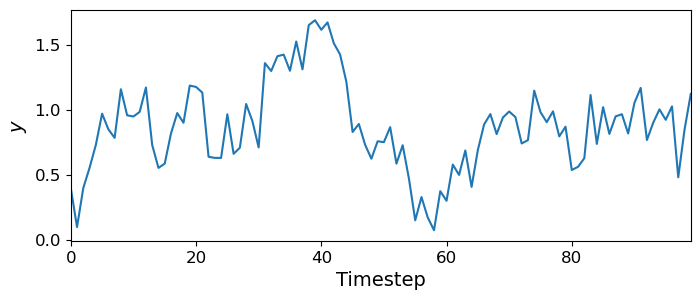

In [16]:
key = jrnd.PRNGKey(0)
order = 2

T = 100
scale = 0.2
b = jnp.array([0.1, 0.8, 0.1])

assert jnp.sum(jnp.abs(b[1:])) < 1, 'Process has infinite variance'

@jax.jit
def ar_step(carry, epsilon_t):
    y_prev = carry
    y_t = b[0] + jnp.sum(b[1:] * y_prev[::-1]) + epsilon_t
    return jnp.concatenate([y_prev[1:], y_t[None]]), y_t
   
#

key, key_innov, key_init = jrnd.split(key, 3)
innovations = scale * jrnd.normal(key_innov, shape=(T - order, ))
y_init = jnp.array([0.4, 0.1])

_, ys = jax.lax.scan(ar_step, y_init, innovations)
y = jnp.concatenate([y_init, ys])

ground_truth = dict(coefficients=b,
                    sigma_y=scale,
                    y_init=y_init)

plt.figure(figsize=(8, 3))
plt.plot(y)
plt.xlim([0, T-1])
plt.xlabel("Timestep")
plt.ylabel("$y$");

Set up the model:

In [17]:
ar_order = 2
num_coef = ar_order + 1

ar1_model = Model(f'AR({ar_order})')
noise_node = ar1_model.add_node('sigma_y', distribution=dx.Transformed(dx.Normal(0, 1), tfb.Exp()))
coeff_node = ar1_model.add_node('coefficients', distribution=dx.Normal(loc=jnp.zeros((num_coef, )), scale=jnp.ones((num_coef))))
init_obs = ar1_model.add_node('y0', distribution=dx.Normal(loc=jnp.zeros((ar_order, )), scale=jnp.ones((ar_order, ))))
obs_node = ar1_model.add_node('y', distribution=AutoRegressionFactory(order=ar_order, include_intercept=True), 
                              parents=dict(coefficients=coeff_node, 
                                           scale=noise_node, 
                                           y_init=init_obs), 
                              observations=y)

Run inference with NUTS:

Adapting NUTS HMC parameters


array([[<Axes: title={'center': '$\\beta_0$'}>,
        <Axes: title={'center': '$\\beta_1$'}>,
        <Axes: title={'center': '$\\beta_2$'}>],
       [<Axes: title={'center': '$\\sigma_y$'}>,
        <Axes: title={'center': '$y_1$'}>,
        <Axes: title={'center': '$y_2$'}>]], dtype=object)

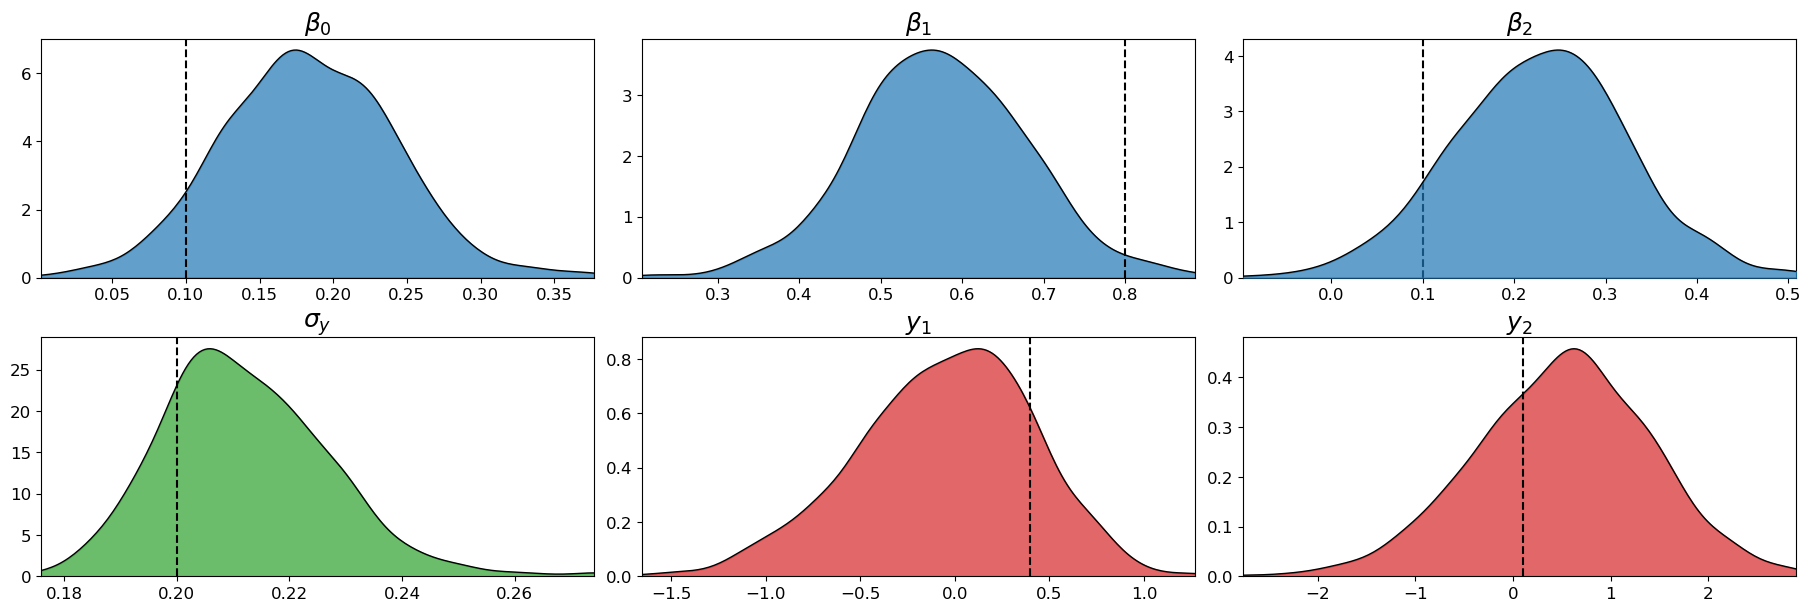

In [ ]:
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(ar1_model.get_model_size()))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=ar1_model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)
engine = MCMCInference(model=ar1_model, num_samples=1000, num_warmup=1000, num_burn=500, num_thin=1, num_chains=1, mcmc_kernel=nuts_kernel)

result_nuts = engine.run(jrnd.PRNGKey(0))
plot_posterior(result_nuts['states'], ground_truth=ground_truth);

Run inference with Gibbs-in-SMC:

coefficients: 0.88
sigma_y: 0.64
y0: 0.28


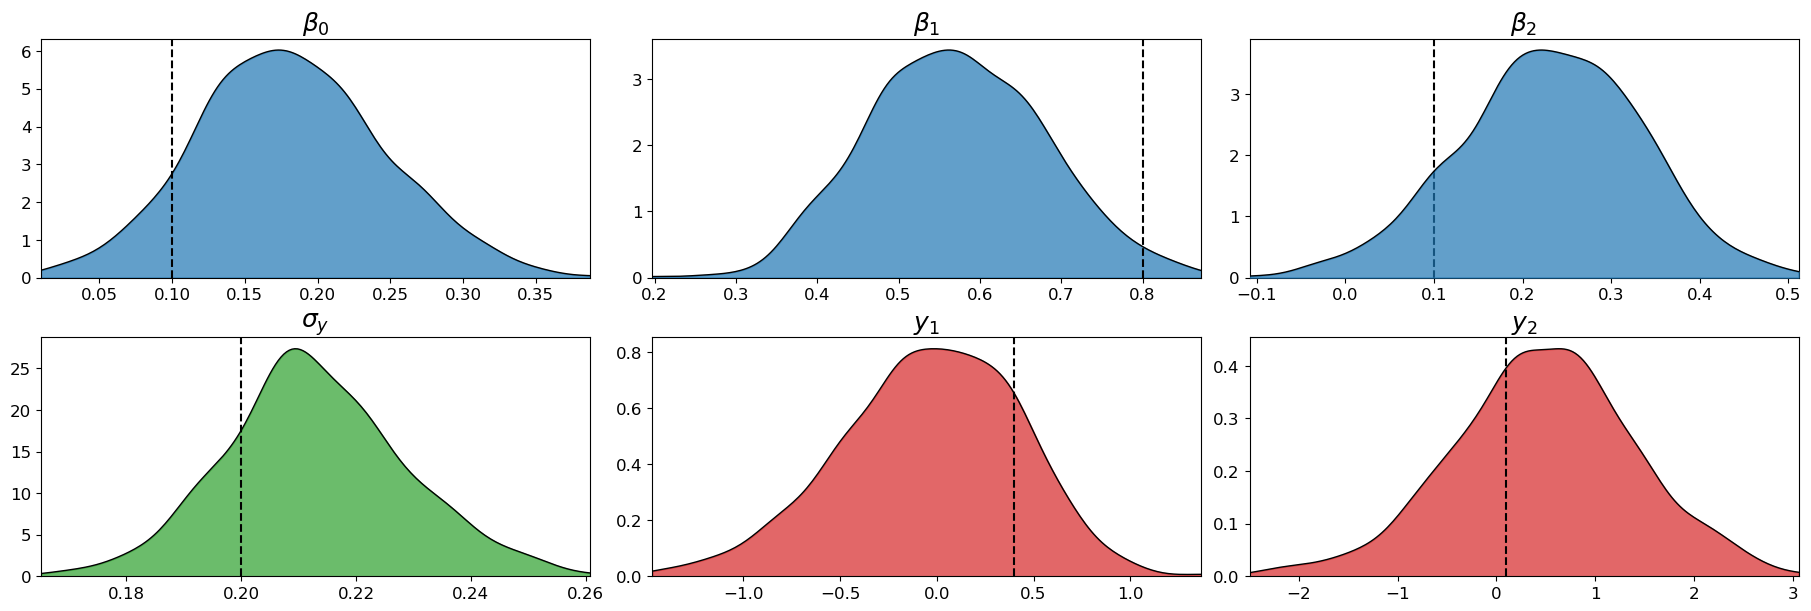

In [18]:
step_fns = dict(sigma_y=blackjax.normal_random_walk, coefficients=blackjax.normal_random_walk, y0=blackjax.normal_random_walk)
step_fn_params = dict(sigma_y=dict(sigma=0.02),
                      coefficients=dict(sigma=0.005*jnp.eye(ar_order + 1)),
                      y0=dict(sigma=1.0))
gibbs_kernel = gibbs_sampler(model=ar1_model, step_fns=step_fns, step_fn_params=step_fn_params)

engine = SMCInference(model=ar1_model, num_particles=1_000, num_mutations=200, mcmc_kernel=gibbs_kernel, return_diagnostics=True)
result_smc = engine.run(key=jrnd.PRNGKey(0))

# tune to reasonable acceptance rates
for k, v in result_smc['final_info'].update_info.items():
    ar = jnp.mean(v.is_accepted)
    print(f'{k}: {ar:0.2f}')

plot_posterior(result_smc['final_state'].particles, ground_truth=ground_truth);

## Mauna Loa $\text{CO}_2$

Download data:

In [19]:
import pandas as pd

mauna_loa_co2 = pd.read_csv('https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv', sep=',', skiprows=40)
mauna_loa_co2['date'] = pd.to_datetime(mauna_loa_co2[['year', 'month']].assign(DAY=1))
dates = mauna_loa_co2['date'].to_numpy()
co2 = mauna_loa_co2['average'].to_numpy()
n = len(co2)

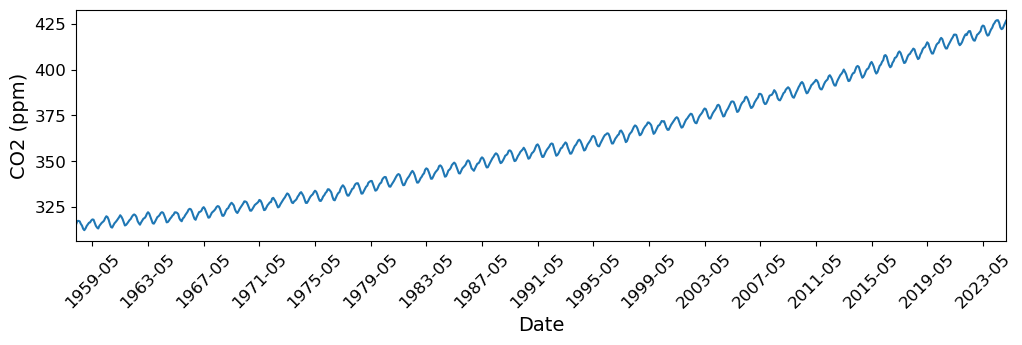

In [20]:
plt.figure(figsize=(12, 3))
ax = plt.gca()
ax.plot(dates, co2)
ax.set_xticks(dates[::12])
ax.set_xticklabels(labels=dates[::12], rotation=45)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=48))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim([dates[0], dates[-1]])
ax.set_xlabel('Date')
ax.set_ylabel('CO2 (ppm)');

Construct model: 

In [21]:
ar_order = 2
num_coef = ar_order + 1

ar1_model = Model(f'AR({ar_order})')
noise_node = ar1_model.add_node('sigma_y', distribution=dx.Transformed(dx.Normal(0, 1), tfb.Exp()))
coeff_node = ar1_model.add_node('coefficients', distribution=dx.Normal(loc=jnp.zeros((num_coef, )), scale=jnp.ones((num_coef))))
init_obs = ar1_model.add_node('y0', distribution=dx.Normal(loc=jnp.zeros((ar_order, )), scale=jnp.ones((ar_order, ))))
obs_node = ar1_model.add_node('y', distribution=AutoRegressionFactory(order=ar_order, include_intercept=True), 
                              parents=dict(coefficients=coeff_node, 
                                           scale=noise_node, 
                                           y_init=init_obs), 
                              observations=co2)

Do inference:

In [22]:
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(ar1_model.get_model_size()))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=ar1_model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)
engine = MCMCInference(model=ar1_model, num_samples=1000, num_warmup=1000, num_burn=500, num_thin=1, num_chains=1, mcmc_kernel=nuts_kernel)

result_nuts = engine.run(jrnd.PRNGKey(0))

Adapting NUTS HMC parameters


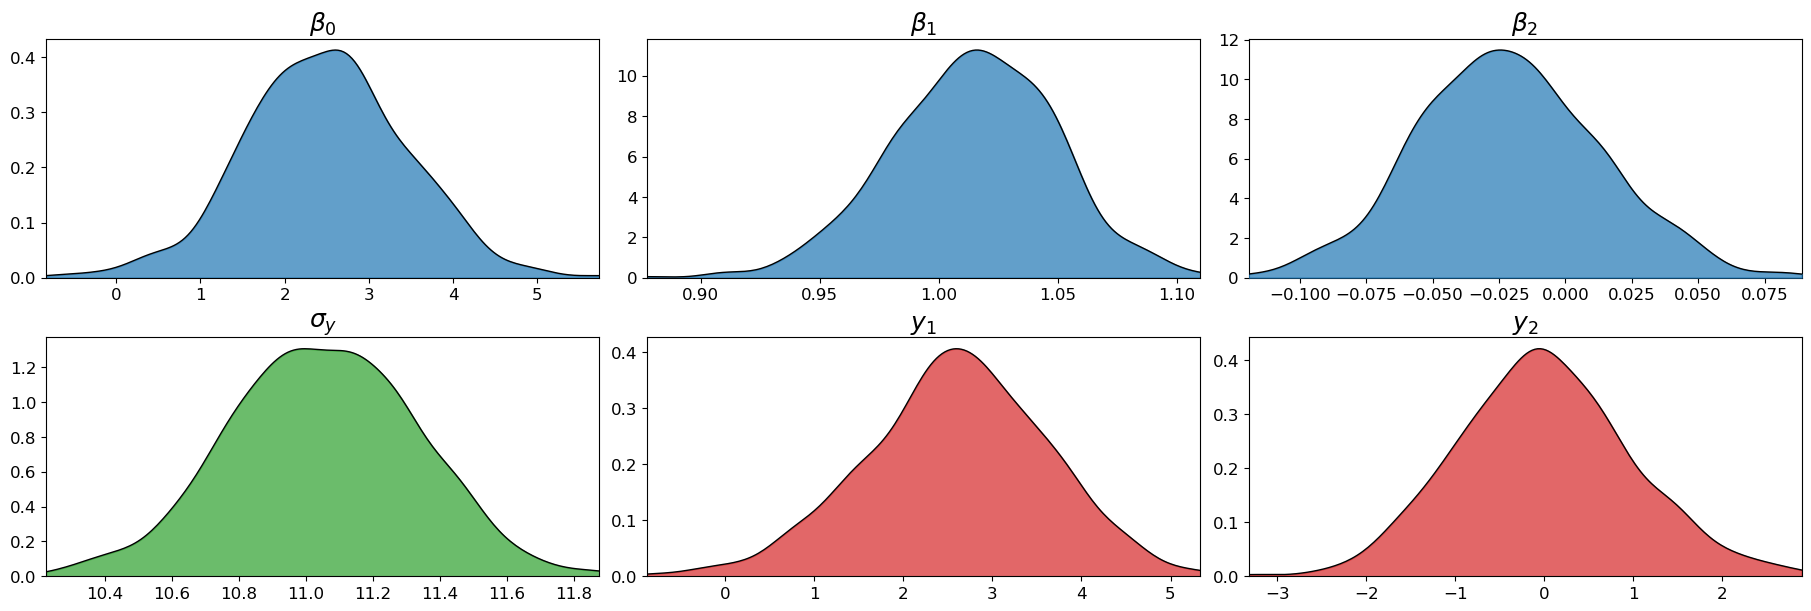

In [23]:
plot_posterior(result_nuts['states']);